In [1]:
%matplotlib inline
import os
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import pandas as pd
import numpy as np
import codecs
import argparse
import math
from scipy.special import comb
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import scipy.integrate as integrate
from scipy.integrate import quad
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from math import floor, log10

parser = argparse.ArgumentParser(description='Plotting data.')
parser.add_argument('--dataset', type=str, help='dataset', default='vool_stats.csv')
parser.add_argument('--inpath', type=str, help='where the dataset is lcoated', default='../../../resources/')
parser.add_argument('--outpath', type=str, help='where to put the charts', default='../../../../output/')
args, unknown = parser.parse_known_args()

# ==============================================================================
# Chart variables
# ==============================================================================
titlesize = 16
subtitlesize = 14
labelsize = 14
axessize = 12
legendsize = 11
markersize = 5

# http://scipy-cookbook.readthedocs.io/items/Matplotlib_LaTeX_Examples.html
plt.rcParams.update(plt.rcParamsDefault)
# plt.style.use('grayscale')
# plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams['mathtext.fontset'] = 'dejavuserif'
font = font_manager.FontProperties(family='serif', size=legendsize)

# Markers - https://matplotlib.org/api/markers_api.html
markers = ["v", "^", "<", ">", "8", "s", "p", "P", "*", "+", "X", "D", "o", "s"]
greyscale = ['silver', 'grey', 'lightgrey', 'black']

# Lines - https://matplotlib.org/gallery/lines_bars_and_markers/line_styles_reference.html

# =============================================================================
# Location String	Location Code
# 'best'	0
# 'upper right'	1
# 'upper left'	2
# 'lower left'	3
# 'lower right'	4
# 'right'	5
# 'center left'	6
# 'center right'	7
# 'lower center'	8
# 'upper center'	9
# 'center'	10
# =============================================================================

# =============================================================================
# These are the "Tableau 20" colors as RGB.
# http://www.randalolson.com/2014/06/28/how-to-make-beautiful-data-visualizations-in-python-with-matplotlib/
# =============================================================================
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]
# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.
for i in range(len(tableau20)):
    r, g, b = tableau20[i]
    tableau20[i] = (r / 255., g / 255., b / 255.)

# ==============================================================================
path = args.inpath
outpath = args.outpath
filename = args.dataset

# datasets = ["Foodmart", "SSB"]  # ["dataset_patrick", "dataset_patrick_ssb"]
# data = pd.DataFrame()
# with codecs.open(path + filename, 'r', encoding='utf-8') as f:
#     data = pd.read_csv(f, sep=';')
#     # data.infer_objects()
# data["dataset"] = data["dataset"].apply(lambda x: "SSB" if "ssb" in x else "Foodmart")
# data["synMeta"] = data["synMeta"] + 1
# msize, m, ls, l, c = marker(filename)

# You typically want your plot to be ~1.33x wider than tall. This plot is a rare
# exception because of the number of lines being plotted on it.
# Common sizes: (10, 7.5) and (12, 9)
# Make room for the ridiculously large title.
# plt.subplots_adjust(top=0.8)
figsize11 = (4, 3)
figsize12 = (8, 3)
figsize13 = (12, 3)
figsize22 = (8, 6)
col_width=0.15

def default_plotsetup(ax):
    ax.grid(color="lightgray", linestyle='-', linewidth=0.3)
    ax.set_axisbelow(True)

In [2]:
df = pd.read_csv(path + filename)

df.describe()
df["module"].unique()
df["time"] = df.apply(lambda x: x["time"] - (1498 if x["module"] not in ["preamble", "mckp", "mkcp", "assess"] else 0), axis=1)
df["time"] = df["time"] + 1
df["time"] = df["time"] / 1000

def round_power_of_10(n):
    import math
    exp = math.log(n, 10)
    exp = round(exp)
    return 10 ** exp

d = {
    "assess": "Assess",
    "skyline": "Skyline",
    "clustering": "Clustering",
    "cardvariance": "CardVariance",
    "sadincrease": "SliceVariance",
    "outlierdetection": "OutlierDetection",
    "preamble": "Preamble",
    "correlation": "Correlation",
    "intravariance": "AggregationVariance"
}
df["module"] = df["module"].replace(d)
df["time"] = df["time"].apply(lambda x: x) #round_power_of_10(x)
# df = df[df["seed"] == df["seed"].max()]
df = df[df["card"] == df["limit"]]
df = df[df["module"] != "univariance"]
df[df["time"] < 0]
df

,card,cube,limit,module,npatterns,seed,sessionid,time,uid
0,100,sales_fact_1997,100,Preamble,1,0,0,0.018,0
1,100,sales_fact_1997,100,OutlierDetection,4,0,0,0.180,0
2,100,sales_fact_1997,100,Clustering,2,0,0,0.231,0
3,100,sales_fact_1997,100,mkcp,3,0,0,0.007,0
15,100,sales_fact_1997,100,Preamble,1,0,1,0.001,3
...,...,...,...,...,...,...,...,...,...
785,1000,sales_fact_1997,1000,Preamble,1,2,3,0.001,145
786,1000,sales_fact_1997,1000,Correlation,1,2,3,0.153,145
787,1000,sales_fact_1997,1000,Skyline,1,2,3,0.403,145
788,1000,sales_fact_1997,1000,Clustering,2,2,3,0.469,145


In [3]:
def init_X(left):
    def v(X):
        X = X.sort_values(["time"])
        X["c"] = 1
        # X["cum_time"] = X["time"].cumsum().apply(lambda x: x)
        X["cum_c"] = X["c"].cumsum()
        X["cum_c"] = X.apply(lambda x: x ["cum_c"] / X["cum_c"].max(), axis=1)
        return X
    if not left:
        X = df
    else:
        X = df[(df["uid"] == 118) | (df["uid"] == 132) | (df["uid"] == 150)]
    X = X[X["module"] != "mkcp"].groupby(["uid", "card"]).apply(lambda x: v(x)).reset_index(drop=True)[["uid", "card", "time", "cum_c", "module"]]
    X["id"] = X.apply(lambda x: str(x["uid"]) + "-" + str(x["card"]), axis=1)
    return X

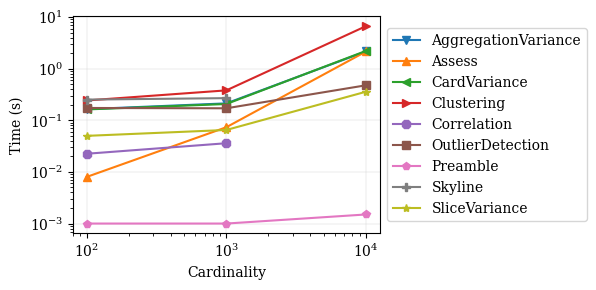

In [6]:
fig, axs = plt.subplots(1, 1, figsize=figsize11)

# X = init_X(True)
# for key, group in X.groupby(["id"]):
#     axs[0].plot(group["time"], group["cum_c"], label=key)
#     default_plotsetup(axs[0])
#     axs[0].set_xscale("log")
#     # axs[0].set_xlim([0.1, 10])
#     # axs[0].set_xticks([0.1, 1, 10])
#     axs[0].legend()

i = 0
X = init_X(False)
for key, group in X.groupby(["module"]):
    ax = axs
    x = group.groupby(["card"])
    x = [x for x in x.groups.keys()]
    y = group.groupby(["card"])["time"].median()
    y = y.tolist()
    ax.plot(x, y, label=key, marker=markers[i])
    i += 1
    default_plotsetup(ax)
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_yticks([0.001, 0.01, 0.1, 1, 10])
    ax.set_xticks([100, 1000, 10000])
    ax.set_xlabel("Cardinality")
    ax.set_ylabel("Time (s)")
fig.tight_layout()
fig